In [19]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import pandas as pd
import time
import sys
import matplotlib.pyplot as plt
import numpy as np

Q3.2 Define constants and experimental setting

In [20]:
img_size = (28, 28)
num_labels = 10
learning_rate = 1e-3
batch_size = 64
num_layers = 2
hidden_size = 1024
num_epochs = 2
# print(type(img_size[0] * img_size[1]))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device {device}")
# print the python version 
print(f"Python version: {sys.version}")
# and pytorch version
print(f"Pytorch version: {torch.__version__}")
# operating system
print("Processor 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz   2.30 GHz")
print("Installed RAM	32.0 GB (31.8 GB usable")
print("Windows 11 Home 64-bit operating system, x64-based processor")

Using device cpu
Python version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pytorch version: 2.2.0+cpu
Processor 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz   2.30 GHz
Installed RAM	32.0 GB (31.8 GB usable
Windows 11 Home 64-bit operating system, x64-based processor


Define dataset

In [21]:
class CsvMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        label = row[0] # first value is the class label
        img = row[1:].values.astype("uint8").reshape(img_size) # reshape 28x28
        img = Image.fromarray(img, mode="L") # L = 8bit greyscale
        if self.transform:
            img = self.transform(img)
        return img, label

Define dataloader and preprocess inputs to have µ=0 and σ=1

In [22]:
# Prepare data
def get_data(batch_size):
    transform_mnist = T.Compose([
        T.ToTensor(), 
        T.Resize(min(img_size[0], img_size[1]), antialias=True), 
        T.CenterCrop(img_size), 
        T.Normalize(mean=[0], std=[1]) # Normalize to 0 mean and 1 std
        ])
    train_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_train.csv',
        transform=transform_mnist,
    )
    test_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_test.csv',
        transform=transform_mnist,
    )

    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    
    for X, y in train_dataloader:
        print(f"Shape of X [B, C, H, W]: {X.shape}") # [batch_size, channels, dims]
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    return train_dataloader, test_dataloader


Define the model architecture according to

| Hyperparameter    | Value |
| --------- | --------- |
| Learning Rate	| 0.001 |
| Batch Size | 64 |
| Hidden Layers |	2 |
| Hidden Size	| 1024 |
| Epochs | 2 |

Q2.3 Count the number of FLOPs in countflops()

The NN is composed an input layer, two hidden layers, and an output layer. Since addition and multiplication count as one operation, the number of FLOPs in a FF single layer is the product of the input dimension squared times the output dimension. For example, the first layer takes an input of 784 and multiplies that with the first layer's 784 weights, doing this 1024 times. The output is of size 1024, where a bias term is added to each element. 

After those 1024 additions, the ReLU layer performs a comparison against 0 for each input to the layer and stores an output value depending on the result for a total of 2 x 1024 operations

Symbolically, a FF network of a layer size [A, B] will have A x A x B + B FLOPs and 2B FLOPs for the ReLU layer, which is represented below.


In [74]:
class MNISTNetwork(nn.Module):
    def __init__(self, image_size=img_size, hidden_layers=2, hidden_size=1024, num_labels=10):
        super(MNISTNetwork, self).__init__()
        # First layer input size must be the dimension of the image
        self.flatten = nn.Flatten()
        # Define NN layers based on the number of layers and hidden size
        flatten_size = image_size[0] * image_size[1] # int
        self.NN_layers = []
        self.NN_layers.append(flatten_size) # first element is input
        for i in range(hidden_layers):
            self.NN_layers.append(hidden_size)
        self.NN_layers.append(num_labels) # output layer size
        NN = []
        for i in range(len(self.NN_layers)-1):
            # [784, 1024] -> ReLU -> [1024, 1024] -> ReLU -> [1024, 10]
            NN.append(nn.Linear(self.NN_layers[i],self.NN_layers[i+1]))
            if i < (hidden_layers):
                NN.append(nn.ReLU())
        self.sequential = nn.Sequential(*NN)
                
    def forward(self, x):
        x = self.flatten(x)
        logits = self.sequential(x)
        return logits
    
    def countflops(self):
        # Count FLOPs per layer [784,1024,1024,10]
        # Linear layer: Ax + b
        # ReLU: b
        # dim(A)[0] * dim(A)[1] + dim(B) + dim(B)
        flop_count = 0
        for i in range(len(self.NN_layers)-1): # 0 to 2
            A = self.NN_layers[i]
            B = self.NN_layers[i+1]
            flop_count += A*A*B+B # linear layer
            if i < (len(self.NN_layers)-2): # before output layer no ReLU
                flop_count += 2*B
        print(f"FLOPs: {flop_count}")
        return flop_count

Q2.1 Define training routine and measure training and inference latencies

In [44]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, cur_epoch):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    model.train()
    start_time = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss = loss.item() / batch_size
        current = (batch + 1) * dataloader.batch_size # number of examples seen in this epoch
        if batch % 500 == 0:
            print(f"Train loss = {loss:>7f}  [{current:>5d}/{size:>5d}]")
    end_time = time.time()
    train_epoch_duration = end_time - start_time
    # print(f"Epoch {cur_epoch+1} training duration: {train_epoch_duration}")
    return train_epoch_duration

# Evaluate train accuracy and loss
def evaluate(dataloader, dataname, model, loss_fn, cur_epoch):
    size = len(dataloader.dataset)
    #start_time = time.time()
    model.eval()
    avg_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    #end_time = time.time()
    avg_loss /= size
    correct /= size
    print(f"{dataname} accuracy = {(100*correct):>0.1f}%, {dataname} avg loss = {avg_loss:>8f}")

def test_evaluate(dataloader, dataname, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    avg_loss, correct, inference_latency, count = 0, 0, 0, 0
    # discard first few iterations
    warmup = 3
    infer_times = []
    with torch.no_grad():
        for X, y in dataloader:
            count += 1
            num_samples = len(y)
            if count > warmup:
                start_time = time.time()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if count > warmup:
                end_time = time.time()
                inference_latency += (end_time - start_time)
                infer_times.append((end_time-start_time)/num_samples) # 1 sample
    avg_loss /= size
    correct /= size
    avg_time_per_inference = inference_latency / (size - num_samples*warmup)
    print(f"{dataname} accuracy = {(100*correct):>0.1f}%, {dataname} avg loss = {avg_loss:>8f}")
    print(f"Average time per example classification: {avg_time_per_inference:>5f} seconds")
    return infer_times, avg_time_per_inference


def new_evaluate(dataloader, dataname, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    avg_loss, correct, inference_latency, count = 0, 0, 0, 0
    # discard first few iterations
    warmup = 3
    infer_times = []
    with torch.no_grad():
        for X, y in dataloader:
            count += 1
            num_samples = len(y)
            if count > warmup:
                start_time = time.time()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if count > warmup:
                end_time = time.time()
                inference_latency += (end_time - start_time)
                infer_times.append((end_time - start_time)/num_samples)
    avg_loss /= size
    correct /= size
    avg_time_per_inference = inference_latency / (size - num_samples*warmup)
    print(f"{dataname} accuracy = {(100*correct):>0.1f}%, {dataname} avg loss = {avg_loss:>8f}")
    print(f"Average time per example classification: {avg_time_per_inference} seconds")
    return correct*100, avg_time_per_inference # return accuracy

Training configuration

In [25]:
print(f"Using {device} device")
train_dataloader, test_dataloader = get_data(batch_size)
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
model = MNISTNetwork().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cpu device
Shape of X [B, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Q3.1 Print training progress and accuracy

The training accuracy is shown below with the run's corresponding hyperparameters.

In [27]:
# Main training 
epoch_train_times = []
epoch_test_times = []
average_inference_time = []
for t in range(num_epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_duration = train_one_epoch(train_dataloader, model, loss_fn, optimizer, t)
    epoch_train_times.append(train_duration)
    evaluate(train_dataloader, "Train", model, loss_fn, t)
    epoch_test, avg = test_evaluate(test_dataloader, "Test", model, loss_fn)
    epoch_test_times.append(epoch_test)
    average_inference_time.append(avg)
# Save the model
torch.save(model.state_dict(), "MNIST_model.pth")
# print("Saved PyTorch Model State to MNIST_model.pth")


Epoch 1
-------------------------------
Train loss = 0.035958  [   64/59999]


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Train loss = 0.004992  [32064/59999]
Train accuracy = 95.8%, Train avg loss = 0.002187
Test accuracy = 95.2%, Test avg loss = 0.002409
Average time per example classification: 0.000028 seconds

Epoch 2
-------------------------------
Train loss = 0.001986  [   64/59999]
Train loss = 0.002061  [32064/59999]
Train accuracy = 97.9%, Train avg loss = 0.000979
Test accuracy = 97.1%, Test avg loss = 0.001481
Average time per example classification: 0.000027 seconds


In [35]:
print(f"Hyperparameters: learning_rate={learning_rate}, \n batch_size={batch_size}, num_layers={num_layers}, hidden_size={hidden_size}, num_epochs={num_epochs}")

Hyperparameters: learning_rate=0.001, 
 batch_size=64, num_layers=2, hidden_size=1024, num_epochs=2


Q3.3 Print the training time per epoch and inference latency per example

In [36]:
for t in range(num_epochs):
    print(f"Epoch {t+1} training duration: {epoch_train_times[t]:>8f}")
print(f"Training time per epoch variance {np.array(epoch_train_times).var():>8f}")

Epoch 1 training duration: 40.264074
Epoch 2 training duration: 43.188599
Training time per epoch variance 2.138212


In [31]:
for t in range(num_epochs):
    print(f"Epoch {t+1} average inference time per sample: {average_inference_time[t]:>8f}")

test_var1 = np.array(epoch_test_times[0]).var()
test_var2 = np.array(epoch_test_times[1]).var()
test_max1 = np.array(epoch_test_times[0]).max()
test_max2 = np.array(epoch_test_times[1]).max()
test_min1 = np.array(epoch_test_times[0]).min()
test_min2 = np.array(epoch_test_times[1]).min()
print(f"Test time per sample variance for epoch 1: {test_var1} seconds")
print(f"Test time per sample variance for epoch 2: {test_var2} seconds")
print(f"Test time per sample max for epoch 1: {test_max1:>8f} seconds")
print(f"Test time per sample max for epoch 2: {test_max2:>8f} seconds")
print(f"Test time per sample min for epoch 1: {test_min1} seconds")
print(f"Test time per sample min for epoch 2: {test_min2} seconds")

Epoch 1 average inference time per sample: 0.000028
Epoch 2 average inference time per sample: 0.000027
Test time per sample variance for epoch 1: 9.536270365409232e-11 seconds
Test time per sample variance for epoch 2: 4.997507011902881e-11 seconds
Test time per sample max for epoch 1: 0.000083 seconds
Test time per sample max for epoch 2: 0.000067 seconds
Test time per sample min for epoch 1: 1.547485589981079e-05 seconds
Test time per sample min for epoch 2: 1.5564262866973877e-05 seconds


The variance for the inferences across the two epochs by default are as shown. What was suprising is that the second epoch has a larger min value for the per sample inference time. The first iteration of inference was not always slower than the others.

Q3.4 Count number of trainable parameters in a function

The values line up as manually calculated as the weight matrices and the bias are the only trainable parameters in a feedforward neural network.

In [32]:
def count_parameters(model):
	total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
	print(f"Total number of model parameters: {total_params}")

count_parameters(model)

# manually computing parameters
# 784*1024 + 1024 + 1024*1024 + 1024 + 1024*10 + 10 = 1863690
NN_layers = [784, 1024, 1024, 10]
total_params = 0
for i in range(len(NN_layers)-1):
	total_params += NN_layers[i] * NN_layers[i+1] + NN_layers[i+1]
print(f'Manually computed total number of model parameters: {total_params}')

Total number of model parameters: 1863690
Manually computed total number of model parameters: 1863690


Q3.5 Count flops

In [38]:
n_flops = model.countflops()

FLOPs: 1713641482


Q3.6 Tune model hyperparameters

The three plots to produce are generated with respect to training 4 various architectures for two epochs


In [115]:
hid_layers = [1,2,3,4]
for nL in hid_layers:
    model = MNISTNetwork(hidden_layers=nL).to(device)
    count_parameters(model)

Total number of model parameters: 814090
Total number of model parameters: 1863690
Total number of model parameters: 2913290
Total number of model parameters: 3962890


In [48]:
hid_layers = [1, 3, 4]
FLOP_arr = []
Acc_arr = []
Latency_arr = []

# log the late
for nL in hid_layers:
    model = MNISTNetwork(hidden_layers=nL).to(device)
    print(model)
    FLOP_arr.append(model.countflops())
    loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_duration = train_one_epoch(train_dataloader, model, loss_fn, optimizer, t)
        evaluate(train_dataloader, "Train", model, loss_fn, t)
    # log the test accuracy and FLOPs of the trained model
    accuracy, avg_infer = new_evaluate(test_dataloader, "Test", model, loss_fn)
    Acc_arr.append(accuracy)
    Latency_arr.append(avg_infer)

# append original model's result
FLOP_arr.append(n_flops)
Acc_arr.append(97.1)
Latency_arr.append(avg) #2.7386016914684993e

MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
FLOPs: 639896586

Epoch 1
-------------------------------
Train loss = 0.035784  [   64/59999]


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Train loss = 0.004485  [32064/59999]
Train accuracy = 96.2%, Train avg loss = 0.001873

Epoch 2
-------------------------------
Train loss = 0.001516  [   64/59999]
Train loss = 0.001934  [32064/59999]
Train accuracy = 97.6%, Train avg loss = 0.001131
Test accuracy = 96.6%, Test avg loss = 0.001570
Average time per example classification: 1.3778265734046535e-05 seconds
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=10, bias=True)
  )
)
FLOPs: 2787386378

Epoch 1
-------------------------------
Train loss = 0.035937  [   64/59999]
Train loss = 0.004060  [32064/59999]
Train accuracy = 95.5%, Train avg loss = 0.002532

Epoch 2
-------------------------------
Train los

Text(0.5, 1.0, 'Acccuracy vs FLOPs')

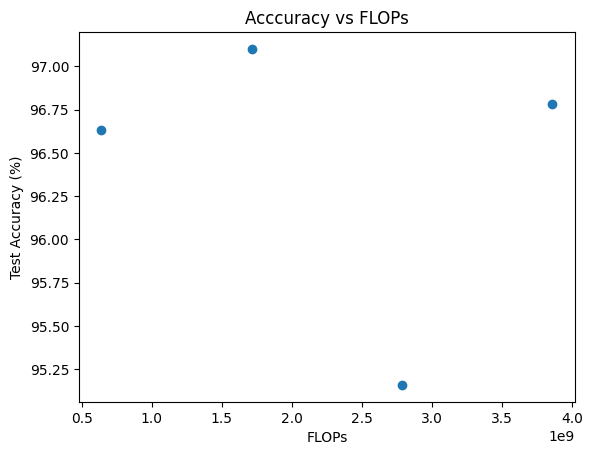

In [77]:
# plot the accuracy vs FLOPs from our base model
plt.scatter(FLOP_arr, Acc_arr)
plt.xlabel('FLOPs')
plt.ylabel('Test Accuracy (%)')
plt.title('Acccuracy vs FLOPs')

The accuracy vs flops plot does not show significant improvement in accuracy using a deeper network, where the the number of FLOPs scales linearly to the depth for one to four hidden layers. All networks' performances are similar.

Text(0.5, 1.0, 'Latency vs FLOPs')

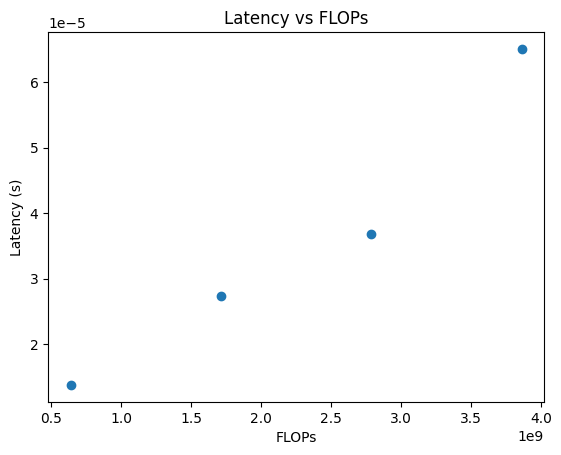

In [68]:
# plot latency vs FLOPs
plt.scatter(FLOP_arr, Latency_arr)
plt.xlabel('FLOPs')
plt.ylabel('Latency (s)')
plt.title('Latency vs FLOPs')

The latency vs FLOPs plot shows a linear proportional relationship between the number of FLOPs and the inference time, which is expected as the time taken to compute a result grows linearly with the amount of operations to perform given a fixed processing speed.

Text(0.5, 1.0, 'Accuracy vs Latency')

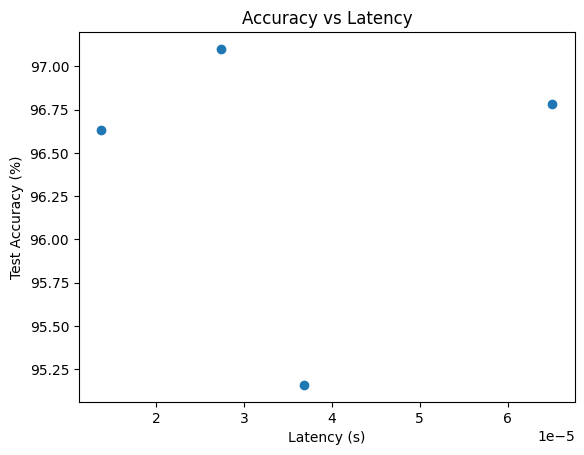

In [70]:
# plot accuracy vs latency
plt.scatter(Latency_arr, Acc_arr)
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Latency (s)')
plt.title('Accuracy vs Latency')

Similar to the accuracy vs FLOPs plot, since latency is proportional to the number of FLOPs, an almost identical spread is found here. There is little or in this case here no boost to the test accuracy after training for two epochs for networks of increasing depth at a fixed hidden size. In fact, more complexity as signified by the inference time per example gave worse results, which could be due to having too many parameters that were detrimental or not sufficiently trained to give better results.

Q3.7 Train on variety of widths

Generate the same three plots as 3.6

In [116]:
hid_widths = [1, 8, 1024, 2048]
for nH in hid_widths:
    model = MNISTNetwork(hidden_size=nH).to(device)
    count_parameters(model)

Total number of model parameters: 807
Total number of model parameters: 6442
Total number of model parameters: 1863690
Total number of model parameters: 5824522


In [83]:
hid_widths = [1, 8, 2048]
width_FLOP_arr = []
width_acc_arr = []
width_latency_arr = []

# log the late
for nH in hid_widths:
    model = MNISTNetwork(hidden_size=nH).to(device)
    print(model)
    width_FLOP_arr.append(model.countflops())
    loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_duration = train_one_epoch(train_dataloader, model, loss_fn, optimizer, t)
        evaluate(train_dataloader, "Train", model, loss_fn, t)
    # log the test accuracy and FLOPs of the trained model
    accuracy, avg_infer = new_evaluate(test_dataloader, "Test", model, loss_fn)
    width_acc_arr.append(accuracy)
    width_latency_arr.append(avg_infer)
# add first model's results
width_FLOP_arr.append(n_flops)
width_acc_arr.append(97.1)
width_latency_arr.append(avg) #2.7386016914684993e

MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1, out_features=10, bias=True)
  )
)
FLOPs: 614683

Epoch 1
-------------------------------
Train loss = 0.038399  [   64/59999]


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Train loss = 0.036969  [32064/59999]
Train accuracy = 9.9%, Train avg loss = 0.036179

Epoch 2
-------------------------------
Train loss = 0.035822  [   64/59999]
Train loss = 0.036080  [32064/59999]
Train accuracy = 11.2%, Train avg loss = 0.035981
Test accuracy = 11.4%, Test avg loss = 0.036133
Average time per example classification: 1.0476501346808111e-05 seconds
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
  )
)
FLOPs: 4918458

Epoch 1
-------------------------------
Train loss = 0.036627  [   64/59999]
Train loss = 0.010918  [32064/59999]
Train accuracy = 84.7%, Train avg loss = 0.008161

Epoch 2
-------------------------------
Train loss = 0.007862  [   64/59999]
Train loss = 0.007736  [32064/59999]
Train accuracy = 88.5%, Train a

Text(0.5, 1.0, 'Acccuracy vs FLOPs')

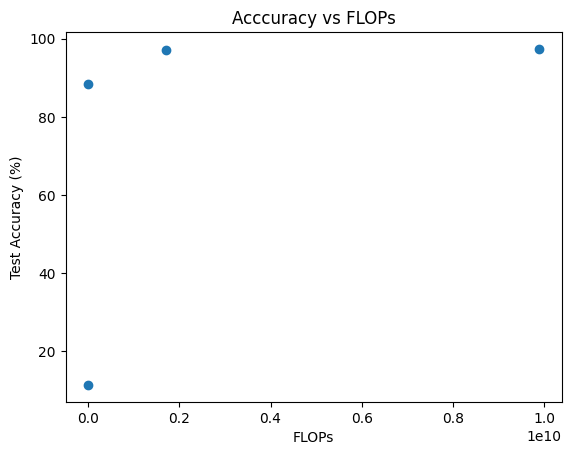

In [84]:
# plot the accuracy vs FLOPs from our base model
plt.scatter(width_FLOP_arr, width_acc_arr)
plt.xlabel('FLOPs')
plt.ylabel('Test Accuracy (%)')
plt.title('Acccuracy vs FLOPs')

In this plot, a hidden size of 1 fails to capture complexity of the standard image and performs barely any better than a purely random guesser that would achieve a 10% accuracy. As the model increases in complexity with a hidden size of 8, accuracy markedly improves. When the default hidden size of 1024 or double that is applied, marginal gains are achieved for far more computations, showing that there is a saturation and diminishing returns from increasing width.

Text(0.5, 1.0, 'Latency vs FLOPs')

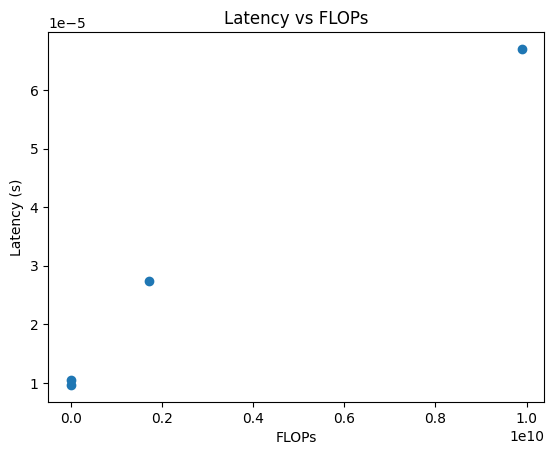

In [85]:
# plot latency vs FLOPs
plt.scatter(width_FLOP_arr, width_latency_arr)
plt.xlabel('FLOPs')
plt.ylabel('Latency (s)')
plt.title('Latency vs FLOPs')

The trend that latency is proportional to the number of FLOPs is observed here again, which agrees with the reasoning above from the corresponding plot of Q3.6.

Text(0.5, 1.0, 'Accuracy vs Latency')

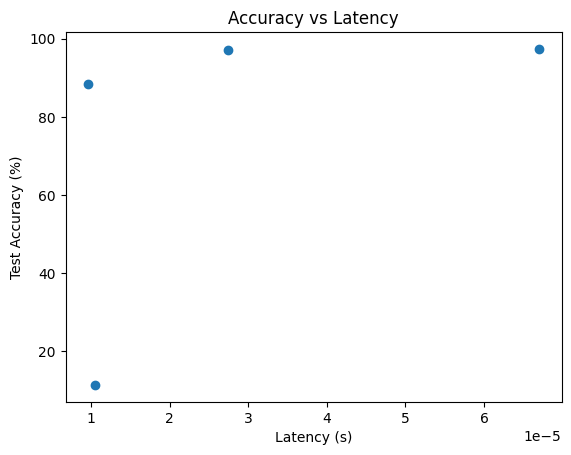

In [86]:
# plot accuracy vs latency
plt.scatter(width_latency_arr, width_acc_arr)
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Latency (s)')
plt.title('Accuracy vs Latency')

Again, a plateauing curve is outlined with the data points, showing that a critical model complexity between a hidden size of 1 to 8 allows the model to learn how to classify the digits.

3.8 Visual transform 1: resize to half size

In [62]:
def get_transform1_data(batch_size):
    transform_mnist = T.Compose([
        T.ToTensor(), 
        T.Resize(min(img_size[0]//2, img_size[1]//2), antialias=True),
        T.Normalize(mean=[0], std=[1]) # Normalize to 0 mean and 1 std
        ])
    train_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_train.csv',
        transform=transform_mnist,
    )
    test_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_test.csv',
        transform=transform_mnist,
    )

    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    
    for X, y in train_dataloader:
        print(f"Shape of X [B, C, H, W]: {X.shape}") # [batch_size, channels, dims]
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    return train_dataloader, test_dataloader

In [117]:
transform1_train_dataloader, transform1_test_dataloader = get_transform1_data(batch_size)
transform1_model = MNISTNetwork(image_size=(14,14)).to(device)
count_parameters(transform1_model)
print(transform1_model)
loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
optimizer = torch.optim.Adam(transform1_model.parameters(), lr=learning_rate)

Shape of X [B, C, H, W]: torch.Size([64, 1, 14, 14])
Shape of y: torch.Size([64]) torch.int64
Total number of model parameters: 1261578
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


In [76]:
hid_layers = [1, 2, 3, 4]
transform1_FLOP_arr = []
transform1_Acc_arr = []
transform1_Latency_arr = []

# log the late
for nL in hid_layers:
    model = MNISTNetwork(image_size=(14,14), hidden_layers=nL).to(device)
    print(model)
    transform1_FLOP_arr.append(model.countflops())
    loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_duration = train_one_epoch(transform1_train_dataloader, model, loss_fn, optimizer, t)
        evaluate(transform1_train_dataloader, "Train", model, loss_fn, t)

    # log the test accuracy and FLOPs of the trained model
    transform1_accuracy, transform1_avg_infer = new_evaluate(transform1_test_dataloader, "Test", model, loss_fn)
    transform1_Acc_arr.append(transform1_accuracy)
    transform1_Latency_arr.append(transform1_avg_infer)

MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
FLOPs: 49826826

Epoch 1
-------------------------------
Train loss = 0.035894  [   64/59999]


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Train loss = 0.004625  [32064/59999]
Train accuracy = 94.8%, Train avg loss = 0.002701

Epoch 2
-------------------------------
Train loss = 0.001870  [   64/59999]
Train loss = 0.003216  [32064/59999]
Train accuracy = 96.5%, Train avg loss = 0.001798
Test accuracy = 96.6%, Test avg loss = 0.001826
Average time per example classification: 1.1050823296747558e-05 seconds
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
FLOPs: 1123571722

Epoch 1
-------------------------------
Train loss = 0.035893  [   64/59999]
Train loss = 0.004219  [32064/59999]
Train accuracy = 96.1%, Train avg loss = 0.002013

Epoch 2
-------------------------------
Train loss = 0.001004  [   64/59999]
Train loss = 0.002034  [32064/59999]
Train accuracy 

Text(0.5, 1.0, 'Acccuracy vs FLOPs')

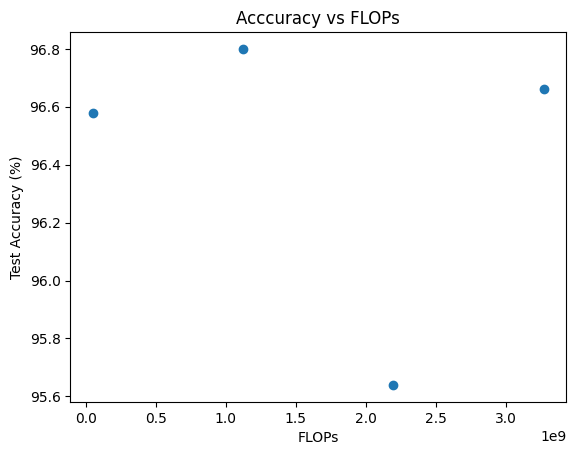

In [87]:
# plot the accuracy vs FLOPs from our base model
plt.scatter(transform1_FLOP_arr, transform1_Acc_arr)
plt.xlabel('FLOPs')
plt.ylabel('Test Accuracy (%)')
plt.title('Acccuracy vs FLOPs')

Compared to Q3.6 that uses the original size image, the compression to a half dimension image of 14 x 14 preserved enough information for the neural network to correctly identify digits. This suggests that the data is simple and lacks complex features that a quarter of the pixels can still capture the complexity, as proven by the network achieving similar accuracy for the number of flops.

Text(0.5, 1.0, 'Latency vs FLOPs')

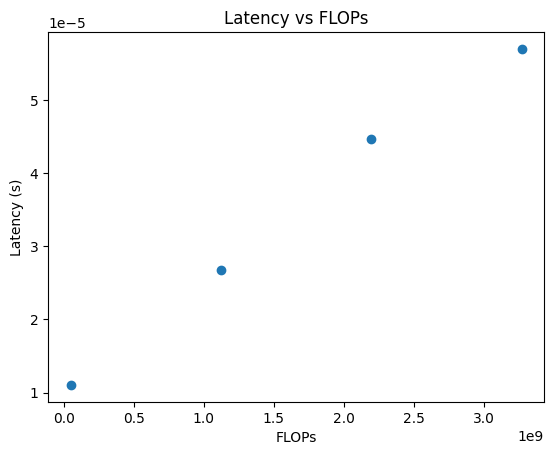

In [79]:
# plot latency vs FLOPs
plt.scatter(transform1_FLOP_arr, transform1_Latency_arr)
plt.xlabel('FLOPs')
plt.ylabel('Latency (s)')
plt.title('Latency vs FLOPs')

Unsurprisingly, the linear relationship between the number of flops and inference is maintained.

Text(0.5, 1.0, 'Accuracy vs Latency')

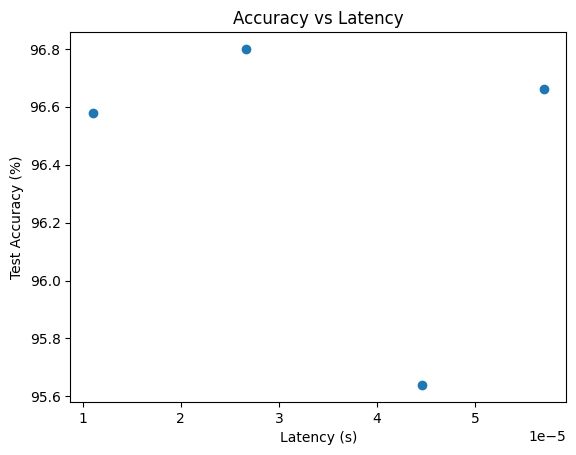

In [80]:
# plot accuracy vs latency
plt.scatter(transform1_Latency_arr, transform1_Acc_arr)
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Latency (s)')
plt.title('Accuracy vs Latency')

Similar to the accuracy vs latency, the model has achieved enough complexity for any depth between 1 and 4 that a common hidden size of 1024 is able to learn the difference between the digits. The accuracies fluctuate between 95% and 97%

3.8 Visual transform 2: cropping to center 14 x 14 pixels

In [88]:
def get_transform2_data(batch_size):
    transform_mnist = T.Compose([
        T.ToTensor(), 
        T.Resize(min(img_size[0], img_size[1]), antialias=True), 
        T.CenterCrop((14,14)), 
        T.Normalize(mean=[0], std=[1]) # Normalize to 0 mean and 1 std
        ])
    train_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_train.csv',
        transform=transform_mnist,
    )
    test_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_test.csv',
        transform=transform_mnist,
    )

    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    
    for X, y in train_dataloader:
        print(f"Shape of X [B, C, H, W]: {X.shape}") # [batch_size, channels, dims]
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    return train_dataloader, test_dataloader

In [118]:
transform2_train_dataloader, transform2_test_dataloader = get_transform2_data(batch_size)
train_size = len(transform2_train_dataloader.dataset)
test_size = len(transform2_test_dataloader.dataset)
transform2_model = MNISTNetwork(image_size=(14,14)).to(device)
count_parameters(transform2_model)
print(transform2_model)
loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
optimizer = torch.optim.Adam(transform2_model.parameters(), lr=learning_rate)

Shape of X [B, C, H, W]: torch.Size([64, 1, 14, 14])
Shape of y: torch.Size([64]) torch.int64
Total number of model parameters: 1261578
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


In [90]:
hid_layers = [1, 2, 3, 4]
transform2_FLOP_arr = []
transform2_Acc_arr = []
transform2_Latency_arr = []

# log the late
for nL in hid_layers:
    model = MNISTNetwork(image_size=(14,14), hidden_layers=nL).to(device)
    print(model)
    transform2_FLOP_arr.append(model.countflops())
    loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_duration = train_one_epoch(transform2_train_dataloader, model, loss_fn, optimizer, t)
        evaluate(transform2_train_dataloader, "Train", model, loss_fn, t)

    # log the test accuracy and FLOPs of the trained model
    transform2_accuracy, transform2_avg_infer = new_evaluate(transform2_test_dataloader, "Test", model, loss_fn)
    transform2_Acc_arr.append(transform2_accuracy)
    transform2_Latency_arr.append(transform2_avg_infer)

MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
FLOPs: 49826826

Epoch 1
-------------------------------
Train loss = 0.036430  [   64/59999]


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Train loss = 0.004889  [32064/59999]
Train accuracy = 93.9%, Train avg loss = 0.003042

Epoch 2
-------------------------------
Train loss = 0.002176  [   64/59999]
Train loss = 0.003092  [32064/59999]
Train accuracy = 95.8%, Train avg loss = 0.002057
Test accuracy = 95.2%, Test avg loss = 0.002333
Average time per example classification: 1.0501650985953845e-05 seconds
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
FLOPs: 1123571722

Epoch 1
-------------------------------
Train loss = 0.035932  [   64/59999]
Train loss = 0.004700  [32064/59999]
Train accuracy = 94.7%, Train avg loss = 0.002695

Epoch 2
-------------------------------
Train loss = 0.002377  [   64/59999]
Train loss = 0.003229  [32064/59999]
Train accuracy 

Text(0.5, 1.0, 'Acccuracy vs FLOPs')

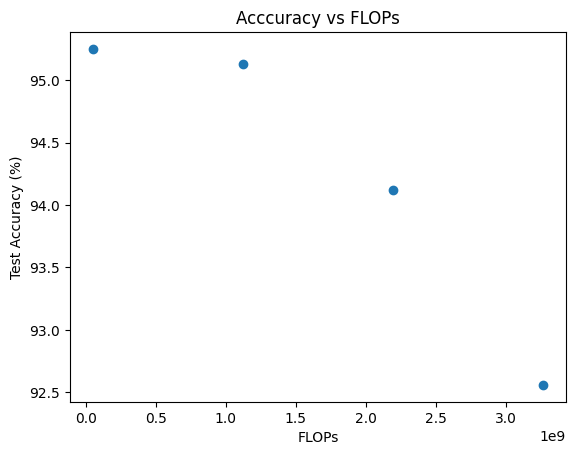

In [106]:
plt.scatter(transform2_FLOP_arr, transform2_Acc_arr)
plt.xlabel('FLOPs')
plt.ylabel('Test Accuracy (%)')
plt.title('Acccuracy vs FLOPs')

When cropping the image to the center 14 x 14 pixels, enough information is preserved about the digits to enable the classifer to distinguish them. That means most of the features are captured in the middle of the image. What is surprising is that the performance worsens significantly more when more hidden layers are added.

Text(0.5, 1.0, 'Latency vs FLOPs')

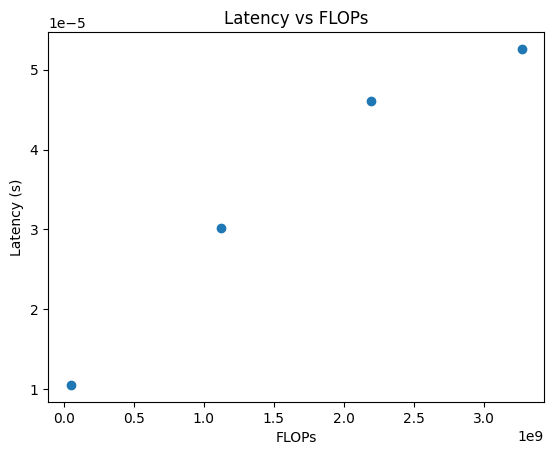

In [107]:
# plot latency vs FLOPs
plt.scatter(transform2_FLOP_arr, transform2_Latency_arr)
plt.xlabel('FLOPs')
plt.ylabel('Latency (s)')
plt.title('Latency vs FLOPs')

A linear relationship between FLOPs and latency is preserved

Text(0.5, 1.0, 'Accuracy vs Latency')

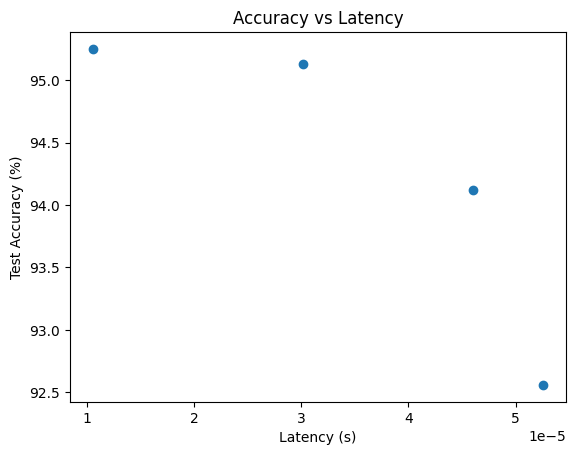

In [108]:
# plot accuracy vs latency
plt.scatter(transform2_Latency_arr, transform2_Acc_arr)
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Latency (s)')
plt.title('Accuracy vs Latency')

The model when cropping the original size image to the center 14 x 14 pixels performs slightly worse than resizing the orignal image to the same dimensions, given the high accuracy. 

Q3.10 Putting it all together 


Building a minimally complex model to achieve >90% accuracy is the general direction to head in. Q3.6 shows that a network with one hidden layer, albeit with 1024 neurons, is sufficiently complex to capture the data.
The findings from Q3.7 that inform a minimum hidden size around 8 producs reasonably high accuracy for how few trainable parameters the model has. Most of the images' information is preserved when resizing the image to 50% of its original dimensions that effectively is a convolutional operation that does an average pooling with a sharpening kernel that preserves edges compared to cropping. Using 1 hidden layer and a hidden size size around 8 but less than 1024 will be tested. 

To do this, two sets of experiments corresponding to the first transformation which resizes images to half the original and a new transformation that maps it to just over a quarter of the original.

Varying hidden sizes will be tested in the list [4, 8, 64, 256] to find what value leads to the an accuracy of >90%. The result from a hidden size of 8 has been cached and can be supplied in the first set of experiments but needs to be done again for the second set. These sets will be plotted on the same axes with different colors to show the type of input data.

In [101]:
def get_small_data(batch_size):
    transform_mnist = T.Compose([
        T.ToTensor(), 
        T.Resize(min(8, 8), antialias=True),
        T.Normalize(mean=[0], std=[1]) # Normalize to 0 mean and 1 std
        ])
    train_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_train.csv',
        transform=transform_mnist,
    )
    test_data = CsvMNISTDataset(
        csv_file='./mnist_data/mnist_test.csv',
        transform=transform_mnist,
    )

    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    
    for X, y in train_dataloader:
        print(f"Shape of X [B, C, H, W]: {X.shape}") # [batch_size, channels, dims]
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    return train_dataloader, test_dataloader

In [103]:
small_train_dataloader, small_test_dataloader = get_small_data(batch_size)
small_model = MNISTNetwork(image_size=(8,8)).to(device)
print(small_model)
loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
optimizer = torch.optim.Adam(small_model.parameters(), lr=learning_rate)

Shape of X [B, C, H, W]: torch.Size([64, 1, 8, 8])
Shape of y: torch.Size([64]) torch.int64
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


In [105]:
resize_config = [1,2]
hid_widths = [4, 8, 64, 256]
small_FLOP_arr = []
small_Acc_arr = []
small_Latency_arr = []

small2_FLOP_arr = []
small2_Acc_arr = []
small2_Latency_arr = []

# log the configurations
for nH in hid_widths:
    model = MNISTNetwork(image_size=(14,14), hidden_layers=1, hidden_size=nH).to(device)
    print(model)
    small_FLOP_arr.append(model.countflops())
    loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_duration = train_one_epoch(transform1_train_dataloader, model, loss_fn, optimizer, t)
        evaluate(transform1_train_dataloader, "Train", model, loss_fn, t)
    # log the test accuracy and FLOPs of the trained model
    small_accuracy, small_avg_infer = new_evaluate(transform1_test_dataloader, "Test", model, loss_fn)
    small_Acc_arr.append(small_accuracy)
    small_Latency_arr.append(small_avg_infer)

# try an 8 x 8 image size
for nH in hid_widths:
    model = MNISTNetwork(image_size=(8,8), hidden_layers=1, hidden_size=nH).to(device)
    print(model)
    small2_FLOP_arr.append(model.countflops())
    loss_fn = nn.CrossEntropyLoss() # no need to softmax as CrossEntropyLoss works on raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_duration = train_one_epoch(small_train_dataloader, model, loss_fn, optimizer, t)
        evaluate(small_train_dataloader, "Train", model, loss_fn, t)
    # log the test accuracy and FLOPs of the trained model
    small_accuracy, small_avg_infer = new_evaluate(small_test_dataloader, "Test", model, loss_fn)
    small2_Acc_arr.append(small_accuracy)
    small2_Latency_arr.append(small_avg_infer)

MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=10, bias=True)
  )
)
FLOPs: 153846

Epoch 1
-------------------------------
Train loss = 0.036048  [   64/59999]


C:\Users\joncc\AppData\Local\Temp\ipykernel_42744\2121649383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0] # first value is the class label


Train loss = 0.025093  [32064/59999]
Train accuracy = 58.4%, Train avg loss = 0.019590

Epoch 2
-------------------------------
Train loss = 0.019998  [   64/59999]
Train loss = 0.018610  [32064/59999]
Train accuracy = 67.6%, Train avg loss = 0.015800
Test accuracy = 67.3%, Test avg loss = 0.015767
Average time per example classification: 6.155146636564329e-06 seconds
MNISTNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=196, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=10, bias=True)
  )
)
FLOPs: 308002

Epoch 1
-------------------------------
Train loss = 0.036158  [   64/59999]
Train loss = 0.012329  [32064/59999]
Train accuracy = 84.6%, Train avg loss = 0.008672

Epoch 2
-------------------------------
Train loss = 0.009825  [   64/59999]
Train loss = 0.007298  [32064/59999]
Train accuracy = 88.1%, Train avg loss = 0.006539
Test accuracy = 88.5%, Test avg loss = 0.006391
Average 

Text(0.5, 1.0, 'Acccuracy vs FLOPs')

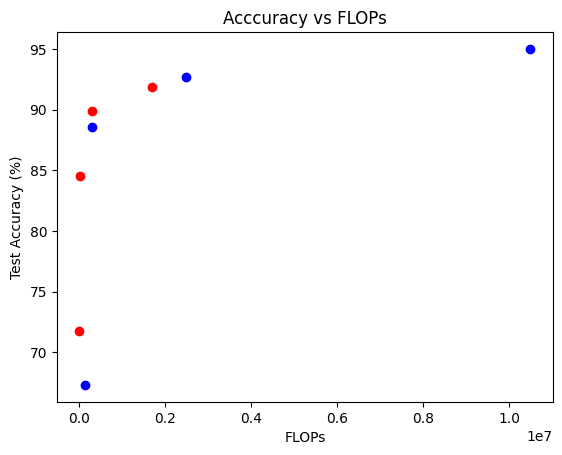

In [114]:
plt.scatter(small_FLOP_arr, small_Acc_arr, color = 'blue')
plt.scatter(small2_FLOP_arr, small2_Acc_arr, color = 'red')
plt.xlabel('FLOPs')
plt.ylabel('Test Accuracy (%)')
plt.title('Acccuracy vs FLOPs')

From the study, the 4th red point from the left, where the next improvment by 2-3% is at triple the computational expense. This indicates that a single layer of hidden size 256 for an original 28 x 28 image shrunk down to an 8 x 8 image is sufficient to achieve the specified accuracy goal.

Another notable datapoint is the 3rd blue point from the left that also exceeds a 90% accuracy but has ~25% more computations for <1% increase in accuracy.

Text(0.5, 1.0, 'Latency vs FLOPs')

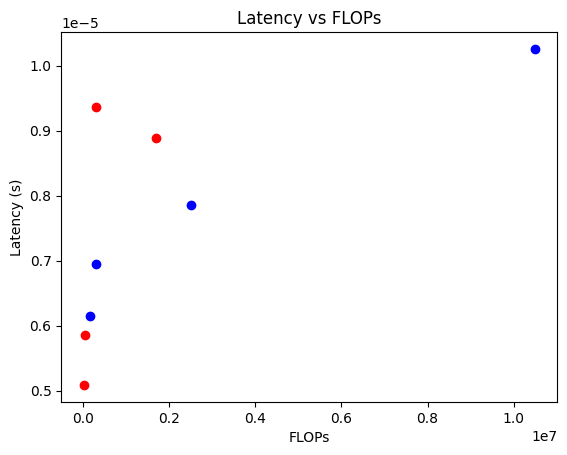

In [110]:
# plot latency vs FLOPs
plt.scatter(small_FLOP_arr, small_Latency_arr, color = 'blue')
plt.scatter(small2_FLOP_arr, small2_Latency_arr, color = 'red')
plt.xlabel('FLOPs')
plt.ylabel('Latency (s)')
plt.title('Latency vs FLOPs')

Tracking the 4th red point from the left and the 3rd blue point from the left, if speed needs to be optimized, the blue model computed faster for some reason. This indicates that though the number of flops might be similar in the previous plot, the types of computation can introduce lag. In this case, the 8 x 8 image size variant with quadruple the hidden size takes longer to propagate through, indicating that PyTorch is slower at computing through wide networks than skinnier ones.

The 3rd red point from the right is an outlier, possibly due to a sudden spike in CPU demand or clock limiting mid-training (the 3rd red point is the seventh out of eight models trained) that inflated the inference time. This could be attributed to thermals, as too high temperatures achieved after training for a while can cause the laptop to throttle its CPU.

Another explanation would be the number of trainable parameters, where the model corresponding to the 4th red point has (8x8+1)x(256)+(256+1)x10 = 19210 whereas the 3rd blue point has (14x14+1)x(64)+(64+1)x10 = 13258 parameters, indicating that the 3rd blue point should take less time to compute.

Text(0.5, 1.0, 'Accuracy vs Latency')

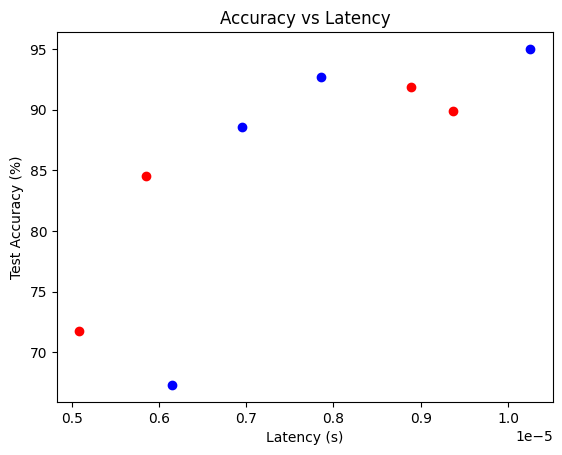

In [113]:
# plot accuracy vs latency
plt.scatter(small_Latency_arr, small_Acc_arr, color = 'blue')
plt.scatter(small2_Latency_arr, small2_Acc_arr, color = 'red')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Latency (s)')
plt.title('Accuracy vs Latency')

If the latency is prioritized, the 3rd blue point from the left is ~12% faster than the next best performer, which is the 3rd red point from the left. This point is identical to the 4th red point from the left in the Accuracy vs FLOPs plot, due to the anomaly observed in the Latency vs FLOPs plot above that was explained.

Final Results

The configuration with an scaled input size of (8,8), hidden size of 256, and 1 hidden layer performed the best for how few FLOPs were required. If inference speed and lowering the number of parameters to train is key, then the configuration with a scaled input size of (14,14), hidden size of 64, and 1 hiddne layer performed the best for how much time is alloted per inference.

Trend-wise, the variation of input size does not affect the performance much, as above 90% accuracy can be achieved with all three sizes (28 x 28), (14 x 14), and (8 x 8). More hidden layers does not help as the features in handwritten digits are simple and can be "understood" by the machine in one layer, given sufficient hidden size. The largest contributor to accuracy is the width of the hidden layer, which was found to be between 64 and 256 if the image is compressed. A larger model size as indicated in the model parameter comparison of the red and blue points generally leads to better performance, though the accuracy will plateau. In the left region of the graph, the trend is particularly observable. In terms of efficiency metrics, the number of FLOPs does not always correspond to the inference time, as the two models discussed in the Latency vs FLOPs plot indicate that smaller models do not always compute faster due to the ratio between additive and multiplicative floating point arithmetic.